Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML , Image
HTML('../style/course.css') #apply general CSS

<a id='instrum:sec:rime'></a><!--\label{instrum:sec:rime}--> 
##  The Radio Interferometer Measurement Equation (RIME)

The RIME naturally emerges as soon as we apply Jones calculus to an interferometric measurement. The purpose of an aperture synthesis interferometer is to measure *complex visibilities*, corresponding to the *coherency* between the E-fields at two different positions, $\langle e_1 e_2^* \rangle$. Let's take a look at how this can be measured.

### 1. A simplified model of a two-element interferometer and correlator

The technical details of interferometric measurements have been covered earlier; for now let us consider a simplified mathematical model. Consider a two-element interferometer. Let us designate the two antennas by the indices $p$ and $q$. Let us designate the E-field vectors at the antenna's nominal positions as $\mathbf{e}_p$ and $\mathbf{e}_q$. 

Each antenna has a dual-receptor feed (because we want to capture full polarization information, i.e. both the $e_x$ and $e_y$ components of the incipient EM field, we must use two receptors, e.g. two orthogonal dipoles. The incoming wavefront induces electrical currents in the receptors, which is what our electronics then sample. For now, think of the measured quantities at each antenna as two sets of complex voltages $v_{p1},v_{p2}$ and $v_{q1},v_{q2}$, or two *voltage vectors*:

$$
\mathbf{v}_p = \left[ \begin{array}{c}v_{p1} \\ v_{p2} \end{array} \right],~~~
\mathbf{v}_q = \left[ \begin{array}{c}v_{q1} \\ v_{q2} \end{array} \right].
$$

These voltages are then fed into a ***correlator***, which computes four complex cross-products called ***correlations***:

$$
V_{11}=\langle v_{p1}v_{q1}^*\rangle,~ V_{12}=\langle v_{p1}v_{q2}^*\rangle,~V_{21}=\langle v_{p2}v_{q1}^*\rangle,~V_{22}=\langle v_{p2}v_{q2}^*\rangle.
$$

Note that at this point we're implicitly assuming that:

* the averaging operation $\langle\cdot\rangle$ is done over a time bin of finite (small) extent $\Delta t$

* the radiation is confined to a narrow frequency bin of $[\nu-\Delta\nu/2,\nu+\Delta\nu/2]$. (In actual fact a correlator will explicitly channelize the incoming signal into a set of narrow frequency channels, so the correlations above are computed per time bin, per frequency channel.)

#### 1.1. The correlation matrix
It proves very convenient to treat the four correlations as a 2x2 matrix, because we can then represent it as the matrix product of $\mathbf{v}_p$ and $\mathbf{v}_q^H$, where $\cdot^H$ is the Hermitian (or conjugate) transpose operator:

$$
\mathbf{V}_{pq} = 
2 \left[ \begin{array}{cc}V_{11} & V_{12} \\ V_{21} & V_{22} \end{array} \right ] =
2\left\langle \left[ \begin{array}{c}v_{p1} \\ v_{p2} \end{array} \right] 
\left[ \begin{array}{cc}v_{q1}^* & v_{q2}^* \end{array} \right ] \right\rangle
= 2\langle \mathbf{v}_p \mathbf{v}_q^H \rangle .
$$

(NB: the factor of 2 is used as a matter of convention, see [<cite data-cite='2011A&A...527A.106S'>Revisiting the radio interferometer measurement equation. I. A full-sky Jones formalism</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.106S) for details). 

$\mathbf{V}_{pq}$ is called the ***correlation matrix***, or often the ***visibility matrix***. The two terms are used somewhat interchangeably -- as we'll see below, the measured correlations correspond to the "true" underlying visibilities, "corrupted" by the instrument response. 

#### 1.2. Enter Jones
Recall from the previous notebook that the voltage vectors at each antenna can be expressed as a product of the "source" EM field vector $\mathbf{e}$ and a 2x2 Jones matrix describing the entire signal propagation path from source to receiver. Since the signal comes to the two antennas via two different paths, each antenna will have its own Jones matrix:

$$
\mathbf{v}_p = \mathbf{J}_p \mathbf{e},~~~ 
\mathbf{v}_q = \mathbf{J}_q \mathbf{e}.
$$

Substituting this into the correlation matrix above, we have:

$$
\mathbf{V}_{pq} 
= 2\langle (\mathbf{J}_p \mathbf{e}) ( \mathbf{J}_p \mathbf{e})^H \rangle 
= 2\langle \mathbf{J}_p \mathbf{e}\mathbf{e}^H \mathbf{J}_q^H \rangle 
= \mathbf{J}_p \, 2\langle \mathbf{e}\mathbf{e}^H \rangle \, \mathbf{J}_q^H~~~~~~~~~(\mathrm{using} (\mathbf{AB})^H = \mathbf{B}^H\mathbf{A}^H).
$$
<p class=conclusion>
Note that this implicitly assumes that ***Jones matrices are constant over the averging interval***.
</p>
<span style="background-color:cyan">GSF:use a different script style for the brightness matrix, prehaps mathsf{} or mathcal{}? have been asked by students from clarification with respect to the bandpass Jones term.</span>

Let us now assume a single source of radiation in the sky. The quantity in the angle brackets, $2\langle \mathbf{e}\mathbf{e}^H\rangle$, is then called the **source brightness matrix**, designated $\mathbf{B}$ (Note: though the notation is the same, this is different from the the B-Jones term which represents the bandpass).
Using the definition of the Stokes parameters in the previous notebook, we get a particularly elegant expression for $\mathbf{B}$ in terms of $IQUV$:

$$
\mathbf{B} = 2\langle \mathbf{e}\mathbf{e}^H\rangle = 2 \left[ \begin{array}{cc}e_x e_x^* & e_x e_y^* \\ 
e_y e_x^* & e_y e_y^*  \end{array} \right ] =
\left[ \begin{array}{cc}I+Q & U+iV \\ 
U-iV & I-Q \end{array} \right ]
$$

In [2]:
def brightness(I, Q, U, V):
    """ Create a brightness matrix from the supplied stokes parameters """

    # Sanity checks
    assert I.ndim == Q.ndim == U.ndim == V.ndim == 1, \
        "Stokes parameters should only have one dimension."
    assert I.shape == Q.shape == U.shape == V.shape, \
        "I, Q, U and V do not have the same shape."

    # Setup our array dimensions
    nsrc = I.shape[0]

    # Create a nsrc x 2 x 2 matrix to hold the complex polarisation values
    B = np.empty(shape=(nsrc, 2, 2), dtype=np.complex128)

    # Compute the polarisation values
    B[:,0,0] = I + Q
    B[:,0,1] = U + V*1j
    B[:,1,0] = U - V*1j
    B[:,1,1] = I - Q

    return B

### 2. The basic RIME of a point source<a id='instrum:sec:rime:point_source'></a><!--\label{instrum:sec:rime:point_source}-->	
This gives us the most basic form of the RIME:

$$
\mathbf{V}_{pq} = \mathbf{J}_{p} \mathbf{B} \mathbf{J}_{q}^H,
$$

that is, the measured correlation matrix is a product of three 2x2 matrices -- a Jones matrix representing the signal path to antenna $p$, a brightness matrix capturing the intrinsic properties (flux, polarization) of the source, and a Jones matrix representing the effects of the signal path to antenna $q$.

Recalling the concept of Jones Chains, with mutiple effects in the signal path, we have:

$$
\mathbf{J}_p = \mathbf{J}_{p,n} \mathbf{J}_{p,n-1} \dots \mathbf{J}_{p,1}, 
$$

which gives us the "onion form" of the RIME:

$$
\mathbf{V}_{pq} = \mathbf{J}_{p,n}(\dots( \mathbf{J}_{p,1} \mathbf{B} \mathbf{J}_{q,1}^H)\dots)\mathbf{J}_{q,n}^H.
$$

The onion form explicitly shows how successive "layers" of propagation effects are applied to the signal as it makes its way from the source to the telescope.

#### 2.1. Specific RIMEs vs the general RIME

The general formalism above is commontly referred to as ***The*** Radio Interferometry Measurement Equation, or simply ***The*** Measurement Equation. When we want to describe a specific instrument and/or observation, we string together specific Jones terms, and thus derive ***a*** RIME or ***a*** measurement equation. This is a very important distinction to make!!

For example, here's a RIME describing a very simple observation that takes into account only complex receiver gains and geometric delay:

$$
\mathbf{V}_{pq} = \mathbf{G}_{p} K_p \mathbf{B} K_q^H \mathbf{G}_{q}^H.
$$

Let us now assume a perfect instrument (i.e. gains of unity) and concentrate on the geometric delay term. Our RIME then simplifies to

$$
\mathbf{V}_{pq} = K_p \mathbf{B} K_q^H.
$$

Note: the K-Jones matrix is scalar, hence the use of Roman rather than boldface font to designate it.

#### 2.2. Geometric delays

In a sense, the K-Jones matrix is the most important Jones term of all, since it is exactly what makes interferometry possible. Consider the geometry of our instrument and pick a coordinate system $xyz$ with the $z$ axis pointing towards some reference direction on the celestial sphere $S_0$ (i.e. the direction we want to observe in). By convention, $x$ then is chosen to point East, and $y$ North on the sky. Note that this coordinate system is fixed to the sky, and the Earth rotates relative to it. The coordinate origin $O$ can be chosen arbitrarily. Let us designate the antenna positions in this coordinate system by $\mathbf{u}_p=(u_p,v_p,w_p)$ and $\mathbf{u}_q=(u_q,v_q,w_q)$. Let's assume a source of radiation at direction $S$; the unit length vector towards this direction is designated as $\mathbf{\sigma}$. 

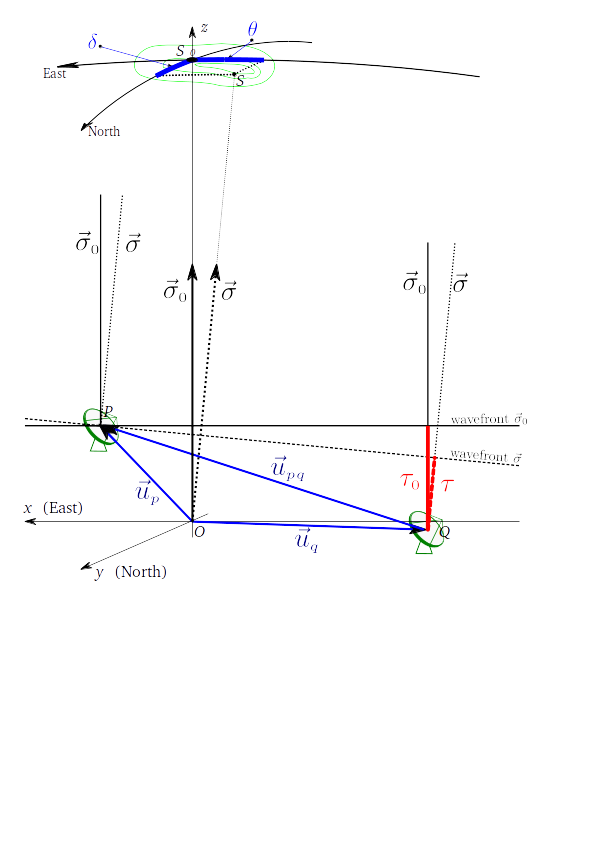

In [3]:
Image(filename="uvw.png")

**Figure 1**: UVW <a id='instrum:fig:uvw'></a><!--\label{instrum:fig:uvw}-->	


The *pathlength difference* of a wavefront arriving from direction $\mathbf{\sigma}$ between the origin $O$ and antenna $p$ is the simply the scalar product $\mathbf{u}_p\cdot\mathbf{\sigma}.$ The K-Jones matrix corresponding to this pathlength difference is a scalar matrix:

$$
K_p = \mathrm{e}^{-2\pi i (\mathbf{u}_p\cdot\mathbf{\sigma})/\lambda}
$$

where $\lambda$ is the wavelength of the monochromatic signal. Substituting this into the RIME above, and remembering that scalar matrices commute, we have

$$
\mathbf{V}_{pq} = K_p \mathbf{B} K_q^H = \mathbf{B} K_p K_q^H = 
\mathbf{B}\,\mathrm{e}^{-2\pi i ((\mathbf{u}_p - \mathbf{u_q})\cdot\mathbf{\sigma})/\lambda} =
\mathbf{B}\,\mathrm{e}^{-2\pi i (u_{pq}l+v_{pq}m+w_{pq}n)/\lambda},
$$

where $u_{pq},v_{pq},w_{pq}$ are the components of the ***baseline vector*** $\mathbf{u}_{pq}=\mathbf{u}_{p}-\mathbf{u}_{q}$, and $l,m,n$ are the components of the direction vector $\mathbf{\sigma}$ (also called the ***direction cosines***, since they are equal to the cosines of the angle formed by $\mathbf{\sigma}$ w.r.t. the coordinate axes). Note that $n=\sqrt{1-l^2-m^2}$, since $\mathbf{\sigma}$ is a unit length vector.

The complex exponent given by the product of the two antennas' K-terms above ***corresponds to the Fourier transform.*** In that sense, the K-Jones term of the RIME is at the heart of all interferometry. 

In [4]:
def phase(lm, uvw, frequency):
    """
    Compute the complex phase RIME term (the K-Jones),
    given lm and uvw coordinates, as well as
    a list of frequencies.

    Arguments:
        lm : float array of shape (nsrc, 2)
            lm coordinates for each source in radians
        uvw : float array of shape (ntime, na, 3)
            uvw coordinates for each baseline in metres
        frequency : float array of shape (nchan)
            frequencies for each channel in hz

    Returns an array of complex values with
    shape (nsrc, ntime, na, nchan) representing
    the phase term.

    """

    assert lm.ndim == 2 and lm.shape[1] == 2, \
        "lm array should have shape (nsrc, 2)"
    assert uvw.ndim == 3 and uvw.shape[2] == 3, \
        "uvw array should have shape (ntime, na, 3)"
    assert frequency.ndim == 1, \
        "frequency array should have shape (nchan)"

    nsrc = lm.shape[0]
    ntime, na = uvw.shape[0], uvw.shape[1]
    nchan = frequency.shape[0]

    # Reference l and m slices for convenenience and compute n from them
    l, m = lm[:,0], lm[:,0]
    n = np.sqrt(1.0 - l**2 - m**2) - 1.0

    assert not np.isnan(n).any(), \
        ("Some values of l and m produce invalid values for n."
        "Check that 1 - l**2 - m**2 >= 0 holds for all l and m")

    # Reference u, v and w for convenience
    u, v, w = uvw[:,:,0], uvw[:,:,1], uvw[:,:,2]

    # Compute phase from outer product of the source and uvw coordinates
    phase =((np.outer(l, u) + np.outer(m, v) + np.outer(n, w))
        .reshape(nsrc, ntime, na) )

    # Now compute and return the complex phase
    return np.exp(-2*np.pi*1j*phase[:,:,:,np.newaxis]
        *frequency[np.newaxis,np.newaxis,np.newaxis,:]/C)


In [5]:
KAT7_ants = np.array([
    [25.095, -9.095, 0.045],
    [90.284, 26.380, -0.226],
    [3.985, 26.893, 0.000],
    [-21.605, 25.494, 0.019],
    [-38.272, -2.592, 0.391],
    [-61.595, -79.699, 0.702],
    [-87.988, 75.754, 0.138]
], dtype=np.float64)

KAT7_latitude = 21 + 24/60. + 38/3600.

def KAT7_antenna_uvw(ref_ra=60, ref_dec=45):
    """
    Returns the KAT7 antenna UVW coordinates for a given
    pointing direction.
    """
    
    # Simulate KAT7 baseline UVW coordinates in the supplied
    # direction and for the given observation time and lattitude
    bl_uvw = sim_uv(ref_ra=ref_ra, ref_dec=ref_dec,
        observation_length_in_hrs=12, integration_length=3,
        enu_coords=KAT7_ants, latitude=KAT7_lattitude)

    # Check that we get the correct number of baselines
    # including auto-correlations
    na = KAT7_ants.shape[0]   
    nbl = na*(na+1)/2 
    ntime = bl_uvw.shape[0]//nbl
    assert bl_uvw.shape == (ntime*nbl, 3)

    bl_uvw = bl_uvw.reshape(ntime, nbl, 3)

    # Take the 0:na slice as our antenna coordinates
    # The na: slice can be derived from antenna coordinates
    ant_uvw = -bl_uvw[:,0:na,:]

    # Sanity check the result. Use per baseline antenna pair mappings
    # to index the result array. This produces
    # per antenna values for each baseline which,
    # when differenced, should match the original
    # baseline uvw coordinates
    ap_idx = ap_index(ntime=ntime, na=na)

    bl = ant_uvw[ap_idx]
    assert np.allclose(bl[0] - bl[1], bl_uvw)

    return ant_uvw

#### 2.3. Effects of averaging & fringe stopping
In deriving the RIME, we assumed that Jones matrices are constant over the chosen time - and frequency - averaging intervals. For K-Jones, this is clearly not necessarily true -- the $uvw$ coordinate vector changes over time due to the Earth's rotation, and the frequency dependence is explicit in the $1/\lambda$ scaling of the exponent. This results in the phase term $K_{pq}=K_p K_q^H$ being a complex quantity with a rotating complex phase, and **averaging a rotating complex phase (i.e. a *vector average*!) always reduces amplitude**. In interferometry, this effect is known as time/frequency ***smearing***. In exteme cases, if the phase rotates through a cycle or more over the averaging interval, the vector average will be close to 0!

This is easy to illustrate with a simple plot:

Mean amplitude for 10 degree span: 0.999
Mean amplitude for 90 degree span: 0.900
Mean amplitude for 180 degree span: 0.637


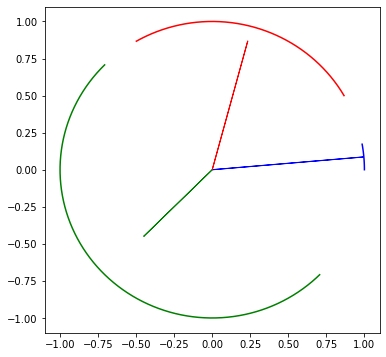

In [6]:
def plot_complex_sequence(start_phase, end_phase, color):
    # make sequence of phases from start to end
    ph = np.arange(start_phase,end_phase,.1)*np.pi/180
    # convert to complex quantity with unit amplitude and given phase, take the mean
    x = np.exp(1j*ph)
    xm = x.mean()
    # plot sequence
    plt.plot(x.real,x.imag,color)
    # plot arrow indicating mean value
    plt.arrow(0,0,xm.real,xm.imag,length_includes_head=True,color=color)
    print ('Mean amplitude for %d degree span: %.3f'%(end_phase-start_phase, abs(xm)))
plt.figure(figsize=(6,6))
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plot_complex_sequence(0,10,'b')
plot_complex_sequence(30,120,'r')
plot_complex_sequence(135,315,'g')

The figure above plots three series of rotating complex vectors (shown by a segment of the arc that the vector rotates through), as well as their vector average (shown by the arrow). The blue arc and arrow corresponds to a vector rotating through $10^\circ$, the red to $90^\circ$, and the green to $180^\circ$. The amplitude loss due to smearing is quite apparent in the last two cases.

Fortunately, we can mimimize the effect of smearing in a particular direction of interest. Consider again the coordinates figure above -- for a wavefront arriving from direction $S_0$ (our directon of interest), the direction vector is $\mathbf{\sigma}_0 = (0,0,1)$, and the corresponding phase term is

$$
\mathrm{e}^{-2\pi i (\mathbf{u}_{pq}\cdot\mathbf{\sigma_0})/\lambda} = \mathrm{e}^{-2\pi i w_{pq}/\lambda}
$$

This phase term corresponds to the excess pathlength $\tau_0$ (see the figure above) associated with baseline $pq$ and direction $S_0$. Since $w_{pq}$ can change as a function of time, averaging over this complex exponent will lead to smearing (i.e. amplitude loss). This can be avoided by having the correlator insert an artificial delay of $-\tau_0$ into its signal chain. The effective K-Jones towards direction $\sigma$ is then given by

$$
K_{pq} = \mathrm{e}^{-2\pi i (u_{pq}l+v_{pq}m+w_{pq}n)/\lambda} \mathrm{e}^{-2\pi i w_{pq}n/\lambda} = 
\mathrm{e}^{-2\pi i (u_{pq}l+v_{pq}m+w_{pq}(n-1))/\lambda},
$$
and for our direction of interest ($\sigma=\sigma_0$) it is simply the constant 1. This technique is known as ***fringe stopping***, since we are effectively "stopping" the complex fringe in the direction $\sigma_0$ from rotating as a function of frequency and time. The effect of fringe stopping is to minimize both the phase and the resulting phase variations of $K_{pq}$ around the reference direction $S_0$. This is the case here, since $l,m,n-1$ are all small numbers for $S$ close to $S_0$.

In a fringe stopping correlator, the K-Jones term becomes

$$
K_p = \mathrm{e}^{-2\pi i (u_{p}l+v_{p}m+w_{p}(n-1))/\lambda}.
$$

Fringe stopping is critically important, since it minimizes amplitude loss due to smearing. It is (almost) universally employed by modern radio correlators.

### 3. The all-sky RIME

Consider again the basic RIME of a point source. The real sky does not contain a single point source, but must rather be described with a brightness distribution. We can express this by making $\mathbf{B}$ a function of direction: $\mathbf{B}(\mathbf{\sigma})$. The signal path from each direction is also different in principle: the Jones matrix should thus also be a function of direction, $\mathbf{J}_p(\mathbf{\sigma})$. Again assuming a linear system, the aggregate correlation $\mathbf{V}_{pq}$ recorded by our interferometer can be obtained by integrating the RIME over the entire celestial spehere:

$$
\mathbf{V}_{pq} = 
\iint\limits_{4\pi} \mathbf{J}_p(\mathbf{\sigma}) \mathbf{B}(\mathbf{\sigma}) \mathbf{J}_q^H(\mathbf{\sigma}) \mathrm{d}\mathbf{\sigma}
$$

To make this integral a little more tractable, let us change variables to $l,m$. This is equivalent to projecting (half of) the celestial spehere onto a plane tangential at $S_0$. We can safely assume that the other half of the sphere is not visible to our instrument: the Earth is in the way...there are a few exotic exceptions to this e.g. space interferometry, but it is generally true. We have:

$$
\mathbf{V}_{pq} = 
\iint\limits_{lm} \mathbf{J}_p(l,m) \mathbf{B}(l,m) \mathbf{J}_q^H(l,m) \frac{\mathrm{d}\mathbf{\sigma}}{\mathrm{d}l\mathrm{d}m} \mathrm{d}l \mathrm{d}m = 
\iint\limits_{lm} \mathbf{J}_p(l,m) \mathbf{B}(l,m) \mathbf{J}_q^H(l,m) \frac{1}{n} \mathrm{d}l \mathrm{d}m,
$$
where the $1/n$ term arises due to a change in the integration volume from $\mathrm{d}\sigma$ to $\mathrm{d}l\mathrm{d}m$.

Let us now split $\mathbf{J}_p$ into direction-dependent and direction-independent parts. Recall that $\mathbf{J}_p$ is a product of a Jones chain of Jones matrices representing successive propagation effects:

$$
\mathbf{J}_p = \mathbf{J}_{p,n} \mathbf{J}_{p,n-1} ... \mathbf{J}_{p,1},
$$

Some of the terms in the chain are functions of $l,m$ and are thus called ***direction-dependent effects*** (DDEs), while others do not depend on $l,m$, and are therefore ***direction-independent effects*** (DIEs). As a general trend (but by no means a rule), effects on the left side of the chain ("in the instrument"), such us electronic gain, will be direction-indpendent effects, while effects on the right of the chain ("in the sky") will be direction-dependent effects. Note that there's always at least one DDE present, and that is the geometric delay term $K_p$. Being scalar, we can commute it to any position in the chain, in particular the right most one. Now, let us designate the **left most** remaining DDE in the chain by $k$ (it is possible that $k=n$, i.e. there are no DIEs).  We have: 

$$
\mathbf{J}_p(l,m) = (\mathbf{J}_{p,n} ... \mathbf{J}_{p,k+1})
(\mathbf{J}_{p,k} ... \mathbf{J}_{p,2}) K_p = \mathbf{G}_p \mathbf{E}_p(l,m) K_p(l,m)
$$

Here, the direction-independent part is designated by $\mathbf{G}$ and the direction-dependent part by $\mathbf{E}$.
Substituting this into the integral, and expanding $K$, we have:

$$
\mathbf{V}_{pq} = \mathbf{G}_p \left( \iint\limits_{lm} \frac{1}{n} \mathbf{E}_p(l,m) \mathbf{B}(l,m) \mathbf{E}_q^H(l,m) \mathrm{e}^{-2\pi i(u_{pq}l+v_{pq}m+w_{pq}(n-1))/\lambda} \mathrm{d}l \mathrm{d}m \right )  \mathbf{G}_q^H,
$$

which is starting to look like a 2D Fourier transform. One final wrinkle remains: the so-called *w-term*. The $w_{pq}(n-1)$ term in the exponent can be split into two per-antenna parts, since $w_{pq}=w_p-w_q$. We can define a notional W-Jones as:

$$
W_p = \frac{1}{\sqrt{n}} \mathrm{e}^{w_p(n-1)},
$$

and treat it as a DDE that can be absorbed in the $\mathbf{E}_p$ part of the Jones chain. Without loss of generality, we can then write:

$$
\mathbf{V}_{pq} = \mathbf{G}_p \left( \iint\limits_{lm} \mathbf{B}_{pq}(l,m) \mathrm{e}^{-2\pi i(u_{pq}l+v_{pq}m)/\lambda} \mathrm{d}l \mathrm{d}m \right )  \mathbf{G}_q^H,~~~\mathbf{B}_{pq} = \mathbf{E}_p \mathbf{B} \mathbf{E}_q^H
$$

If we express the $uv$ coordinates in units of $\lambda$, the $1/\lambda$ term disappears, and the exponent under the integral is simply a 2D Fourier transform kernel. This explicitly shows that the measured correlations are related to a 2D Fourier transform of the sky.

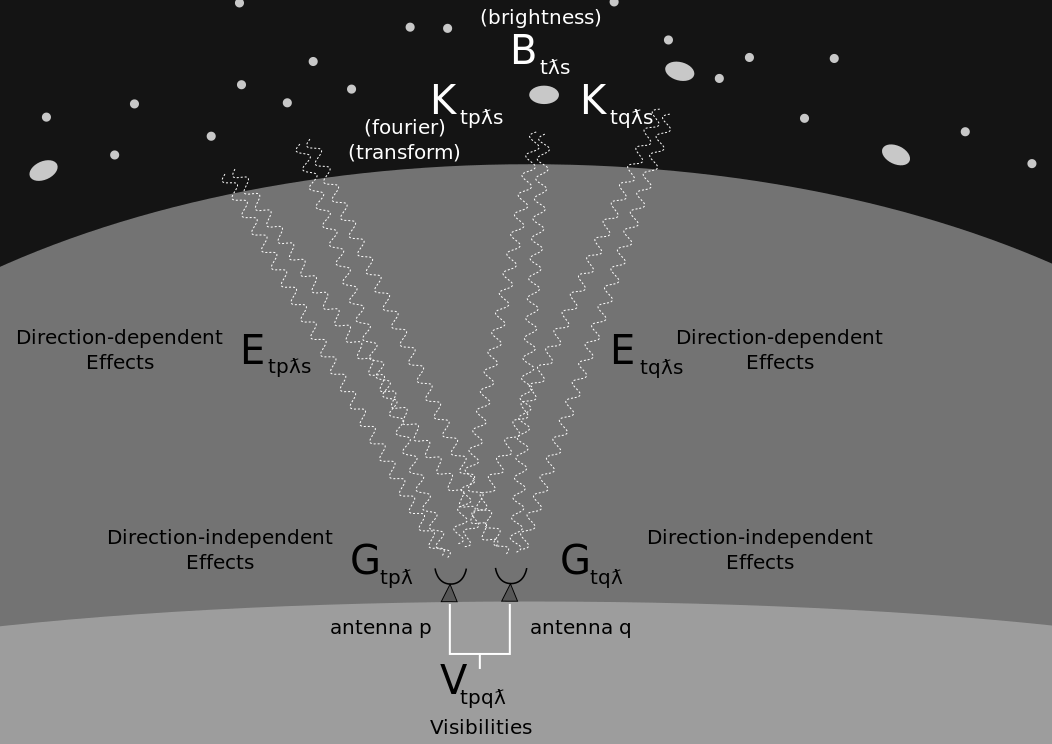

In [7]:
Image(filename ="rime_multiple_sources.png")

**Figure 2**: This diagram illustrates the terms of the Radio Interferometer Measurement Equation (RIME). The emissions of a radio source are characterised by a brightness matrix $\mathbf{B_{t\lambda s}}$. These emission intensities are converted into the frequency domain by a Fourier transform $\mathbf{K_{tp\lambda s}}$, whose frequencies are subject to *direction-dependent and -independent effects*, labelled $\mathbf{E_{tp\lambda s}}$ and $\mathbf{G_{tp\lambda}}$ respectively. Direction-dependent terms frequently model antenna beam, ionospheric and tropospheric effects in a radio source direction. By contrast, direction-independent terms are not associated with a particular direction, and can incorporate effects such as temperature fluctuations and polarisation leakages on the physical antenna. The RIME outputs *model visibilites* $\mathbf{V_{tpq\lambda}}$.
<a id='instrum:fig:dde_and_die'></a><!--\label{instrum:fig:dde_and_die}-->

Another example of a Jones chain is

$$
\mathbf{J} = \mathbf{BG_\mathrm{instr}DE_\mathrm{PB}PT}
$$

where

$\mathbf{B}$ is the Jones matrix corresponding to the bandpass gain, a direction-idependent effect,

$\mathbf{G}_\mathrm{instr}$ is the Jones matrix corresponding to the receiver/instrumental gain, a direction-independent effect,

$\mathbf{D}$ is the Jones matrix corrsponding to polarization leakage, a direction-independent effect,

$\mathbf{E}_\mathrm{PB}$ is the Jones matrix corresponding to the antenna primary beam, a direction-dependent effect,

$\mathbf{P}$ is the Jones matrix corresponding to parallactic angle rotation, a direction-independent effect,

$\mathbf{T}$ is the Jones matrix corresponding to ionospheric and tropospheric effects, which are direction-dependent effects.

<span style="background-color:cyan">GSF: stop fold in of the old 7.3 section</span>

#### 3.1. When is it a Fourier transform? 
An interferometer directly measures visibilities that correspond to a 2D Fourier transform of the sky. This is the underlying assumption of classical interferometry. In the literature you will often see mention of DDEs and "wide field" and the "$w$-term" in the context of breaking this assumption, and thus introducing distortions. The RIME formulation above makes it easy to understand the Fourier transform assumption and what happens when it's broken.

The matrix $\mathbf{B}_{pq}$ in the equation above is known as the ***apparent sky*** *seen by baseline $pq$*. If we assume for a minute that every baseline sees the same apparent sky $\mathbf{B}_\mathrm{app}$ throughout the duration of the measurement (and remember that it may take several hours to fill the $uv$-plane), then the RIME becomes a true Fourier transform:

$$
\mathbf{V}_{pq} = \mathbf{G}_p \left( \iint\limits_{lm} \mathbf{B}_\mathrm{app}(l,m) \mathrm{e}^{-2\pi i(u_{pq}l+v_{pq}m)/\lambda} dl dm \right )  \mathbf{G}_q^H
$$

this is often written in shorthand as

$$
\mathbf{V}_{pq} = \mathbf{G}_p \mathbf{X}_{pq}  \mathbf{G}_q^H
$$

and interpreted as follows: each baseline, at each point in time, observes a *coherency* that corresponds to a 2D Fourier transform of the sky brightness distribution, multiplied by per-antenna G-Jones matrices corresponding to direction-independent instrumental effects. Basic direction independent calibration (also known as second-generation calibration, or 2GC) consists of fitting the $\mathbf{G}$ terms in some sort of least-squares way, and the inverse of the solutions $\mathbf{\tilde G}$ to the observed data, to obtain ***corrected data***

$$
\mathbf{V}_{pq}^\mathrm{(corr)} = \mathbf{\tilde G}_p^{-1} \mathbf{V}_{pq} \mathbf{\tilde G}_q^{-H} \approx \mathbf{X}_{pq}
$$

which is then imaged to obtain an image of the sky.

#### 3.2. Apparent skies and classical interferometry

The question is, when *can* we assume that every baseline sees the same apparent sky? Since $\mathbf{B}_{pq} = \mathbf{E}_p \mathbf{B} \mathbf{E}_q^H$, the abstract answer is simple: when the DDE term $\mathbf{E}_p$ is the same across all antennas, and constant in time. We call such DDEs ***trivial DDEs***:

$$
\mathrm{if}~~\mathbf{E}_p(t) \equiv \mathbf{E}~~\mathrm{for~all}~~t,p,~~\mathrm{then}~~\mathbf{B}_\mathrm{app}=\mathbf{EBE}^H
$$

To understand whether a DDE is trivial or not, we need to consider what effects go into $\mathbf{E}_p$ more closely. For starters, we introduced a W-Jones above and absorbed it into $\mathbf{E}_p$:

$$
W_p = \frac{1}{\sqrt{n}} \mathrm{e}^{w_p(n-1)},
$$

This is generally not a trivial DDE: the $w_p$ coordinate can be different for all antennas, and varies as a function of time (since the Earth rotates). However, if one of two conditions is met:

* the field-of-view is small, therefore $n=\sqrt{1-l^2-m^2}\approx1$

* the array is co-planar and remains so for the duration of the observation (i.e. all antennas lie in a plane), in which case we can choose a coordinate system where all $w_bp=0$

...then the W-Jones term becomes unity and can be neglected. This is called the ***narrow-field assumption*** and the ***coplanarity assumption***. Narrow fields-of-view are the usual case with larger dishes, and/or at higher frequencies. Coplanarity is only possible if:

* we do a short ("snapshot") observation with a small array, or

* our antennas are laid out along an East-West line 

New instruments (LOFAR, MeerKAT, SKA1) tend to be wide-field and thus need to deal with $W$. This is called the *wide-field imaging* problem.

### 4. Mueller calculus
Mueller calculus is an alternative to (or rather, extension of) Jones calculus. The basic rationale of Mueller calculus is as follows. From the Jones formalism, it is obvious that the interferometer response is linear with respect to the four Stokes parameters $I,Q,U,V$. Instead of defining a 2x2 brightness matrix $\mathbf{B}$, let us define the ***Stokes vector*** $\mathbf{b}$ as:

$$
\mathbf{b} = \left[ \begin{array}{c} I \\ Q \\ U \\ V \end{array} \right ] 
$$

We can also define the ***measured Stokes vector*** associated with baseline $pq$. In the case of linear feeds, this is defined as

$$
\mathbf{b}_{pq} = \left[ \begin{array}{c} I' \\ Q' \\ U' \\ V' \end{array} \right ] = \frac{1}{2}
\left[ \begin{array}{c} V_{11}+V_{22} \\ V_{11}-V_{22} \\ V_{12}+V_{21} \\ -\imath(V_{12}-V_{21}) \end{array} \right ] 
$$

For circular feeds, the definition is slightly different:

$$
\mathbf{b}_{pq} = \left[ \begin{array}{c} I' \\ Q' \\ U' \\ V' \end{array} \right ] = \frac{1}{2}
\left[ \begin{array}{c} V_{11}+V_{22} \\ V_{12}+V_{21} \\ -\imath(V_{12}-V_{21}) \\ V_{11}-V_{22} \end{array} \right ] 
$$


In the case of a point source at phase centre, and a perfect telescope with no propagation effects (i.e. Jones matrices of unity), we would have $\mathbf{b}'_{pq} \equiv \mathbf{b}$. If we take propagation effects into account, this equality no longer holds. However: the basic assumption of Jones calculus is that the response of the system is linear. This means that for each baseline, the response may be represented by a 4x4 matrix $\mathbf{M}_{pq}$:

$$
\mathbf{b}_{pq} = \mathbf{M}_{pq} \mathbf{b} 
$$

$\mathbf{M}_{pq}$ is called the ***Mueller matrix*** of baseline $pq$.

#### 4.1. Mueller vs. Jones matrices 
There is a simple relationship between Mueller and Jones matrices. Following [<cite data-cite='1996A&AS..117..137H'>Understanding radio polarimetry. I</cite> &#10548;](http://adsabs.harvard.edu/abs/1996A&AS..117..137H), we can stack the 4 complex visibilities into a ***visibility vector*** :

$$
\mathbf{v}_{pq} = 2 \left[ \begin{array}{c} V_{11} \\ V_{12} \\ V_{21} \\ V_{22} \end{array} \right ] = 2 \mathbf{v}_p \otimes \mathbf{v}^*_q, 
$$

where $\otimes$ denotes the *Kronecker* or *outer product*, and $\mathbf{v}^*_q$ is the element-by-element complex conjugate. This leads to a natural defition of a corresponding ***coherency vector*** $\mathbf{x}$. Since $\mathbf{v}_p = \mathbf{J}_p \mathbf{e}$, we have (in a linear polarization basis)

$$
\mathbf{v}_{pq} = (\mathbf{J}_p \otimes \mathbf{J}^*_q)(2 \mathbf{e} \otimes \mathbf{e}^*) = 
(\mathbf{J}_p \otimes \mathbf{J}^*_q) 
\left[ \begin{array}{c} I+Q \\ U+\imath V \\ U-\imath V \\ I-Q \end{array} \right ] = (\mathbf{J}_p \otimes \mathbf{J}^*_q) \mathbf{x}
$$

The coherency vector $\mathbf{x}$ relates to the Stokes vector $\mathbf{b}$ via a simple conversion matrix $\mathbf{S}$. In the linear basis:

$$
\mathbf{x} = 
\left[ \begin{array}{c} I+Q \\ U+\imath V \\ U-\imath V \\ I-Q \end{array} \right ] =
\left[ \begin{array}{cccc} 1&1&0&0 \\ 0&0&1&\imath \\ 0&0&1&-\imath \\ 1&-1&0&0 \end{array} \right ] 
\left[ \begin{array}{c} I \\ Q \\ U \\ V \end{array} \right ] =
\mathbf{S} \,\mathbf{b}
$$

and the opposite relation is given by the inverse of the conversion matrix:

$$
\mathbf{b} = 
\left[ \begin{array}{c} I \\ Q \\ U \\ V \end{array} \right ] = \frac{1}{2}
\left[ \begin{array}{cccc} 1&0&0&1 \\ 1&0&0&-1\\ 0&1&1&0 \\ 0&-\imath&\imath&0 \end{array} \right ] 
\left[ \begin{array}{c} I+Q \\ U+\imath V \\ U-\imath V \\ I-Q \end{array} \right ] =
\mathbf{S}^{-1}\mathbf{x}
$$  

We can now write the measured Stokes vector as $\mathbf{b}_{pq}=\mathbf{S}^{-1} \mathbf{v}_{pq}$. In the Mueller formalism, the RIME then becomes

$$
\mathbf{b}_{pq} = \mathbf{S}^{-1} (\mathbf{J}_p \otimes \mathbf{J}^*_q) \mathbf{S} \, \mathbf{b} 
$$

The interferometer Mueller matrix is then given by $\mathbf{M}_{pq}=\mathbf{S}^{-1} (\mathbf{J}_p \otimes \mathbf{J}^*_q) \mathbf{S}$.

***

<div class=advice>
**Making sense of the literature**. The original measurement equation (ME) paper [<cite data-cite='1996A&AS..117..137H'>Understanding radio polarimetry. I</cite> &#10548;](http://adsabs.harvard.edu/abs/1996A&AS..117..137H) uses Mueller calculus. [<cite data-cite='2000A&AS..143..515H'>Understanding radio polarimetry. IV</cite> &#10548;](http://adsabs.harvard.edu/abs/2000A%26AS..143..515H) in the ME series introduces the 2x2 Jones calculus. The RIME papers ([<cite data-cite='2011A&A...527A.106S'>Smirnov 2011a</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.106S), [<cite data-cite='2011A&A...527A.107S'>Smirnov 2011b</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.107S), [<cite data-cite='2011A&A...527A.108S'>Smirnov 2011c</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.108S), [<cite data-cite='2011A&A...531A.159S'>Smirnov 2011d</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...531A.159S)) use 2x2 Jones calculus, and straighten out some inconsistencies of the original ME paper series. Unfortunately, they also introduce errors of their own. In particular, within the [<cite data-cite='2011A&A...527A.106S'>Smirnov 2011a</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.106S) paper, eqs. 25-26 and related discussion should use $\mathbf{J}_p \otimes \mathbf{J}^*_q$ and not $\mathbf{J}_p \otimes \mathbf{J}^H_q$.
</div>

<div class=advice>
The factor of 2 in the definition of the visibility matrix $\mathbf{V}_{pq}$ and visibility vector $\mathbf{v}_{pq}$ was introduced in [<cite data-cite='2011A&A...527A.106S'>Smirnov 2011a</cite> &#10548;](http://adsabs.harvard.edu/abs/2011A%26A...527A.106S), for reasons explained in that paper. The original Hamaker papers do not use the factor of 2.
</div>

<div class=advice>
By standard definition (as above), the Mueller matrix gives the linear transfrom between Stokes vectors. You may also come across some non-conventional usage of the term. Sometimes the $(\mathbf{J}_p \otimes \mathbf{J}^*_q)$ matrix, which transforms between visibility vectors, or even the $(\mathbf{J}_p \otimes \mathbf{J}^*_q) \mathbf{S}$ matrix, which transforms Stokes to visibility vectors, is also referred to as the Mueller matrix. This does not conform to the standard definition, but the usage is usually clear from the context so there's little potential for confusion.
</div>


#### 4.2. Mueller chains

By analogy with Jones chains, when the signal chain contains multiple propagation effects, each one can be described by its own Mueller matrix. The Mueller form of the RIME then becomes

$$
\mathbf{b}_{pq} = \mathbf{M}_{pq,n} \mathbf{M}_{pq,n-1} \dots \mathbf{M}_{pq,1} \mathbf{b}, 
$$

Each Mueller matrix in the chain takes the form of 
$\mathbf{M}_{pq,k} = \mathbf{S}^{-1}
(\mathbf{J}_{p,k} \otimes \mathbf{J}^*_{q,k}) 
\mathbf{S}$, and the whole chain can be written as 

$$
\mathbf{b}_{pq} = \mathbf{S}^{-1}
(\mathbf{J}_{p,n} \otimes \mathbf{J}^*_{q,n})(\mathbf{J}_{p,n-1} \otimes \mathbf{J}^*_{q,n-1}) \dots
(\mathbf{J}_{p,1} \otimes \mathbf{J}^*_{q,1})
\mathbf{S} \, \mathbf{b}
$$

This is the Mueller equivalent of the onion form of the RIME.

<div class="advice">
**Why Mueller?** Any RIME can be equivalently recast in 4x4 Mueller or 2x2 Jones form. The Mueller form is often used in formulation of imaging algorithms, since it emphasizes the linear relationship between the true and the measured Stokes parameters. The Jones form of the RIME yields itself more naturally to discussions on calibration, since it emphasizes the per-antenna nature of propagation effects.
</div>